# Customer Lifetime Value Prediction

**CLTV = Conditional Expected Number of Transaction * Conditional Expected Average Profit**

First, the whole customers' behaviours are applied to a model and then make prediction the expected transaction for each customer.

**CLTV = BG/NBD MODEL * GAMMA GAMMA SUBMODEL**

BG/NBD MODEL for expected number of transaction
GAMMA GAMMA SUBMODEL for expected average profit

BG/NBD MODEL : Beta Geometric / Negative Binomial Distribution

**Transaction Process(buy)**
- Possion distribution for the expected number of transaction and transaction rate
- Gamma distribution in whole customers 

**Dropout Process(till you die)**	
- All customers have their dropout probability as p. 
- Beta distribution for dropout rates




## Importing Modules & Dataset


In [1]:
pip install lifetimes

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 13.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

In [3]:
df_ = pd.read_csv("flo_data_20k.csv")
df = df_.copy()

## Exploratory Data Analysis

In [4]:
def check(df, head = 5):
    print("**********************************HEAD**********************************")
    print(df.head(head))
    print("**********************************TAIL**********************************")
    print(df.tail(head))
    print("**********************************TYPES**********************************")
    print(df.dtypes)
    print("**********************************SHAPE**********************************")
    print(df.shape)
    print("**********************************NA**********************************")
    print(df.isnull().sum())
    print("**********************************QUANTILES**********************************")
    print(df.describe([0, 0.05, 0.5, 0.95]))

In [5]:
check(df)

**********************************HEAD**********************************
                              master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online       interested_in_categories_12
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline       2020-10-30      2021-02-26             2021-02-21              2021-02-26                       4.0000                        1.0000                           139.9900                          799.3800                           [KADIN]
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile       2017-02-08      2021-02-16             2021-02-16              2020-01-10                      19.0000                        2.0000                           159.9700                         1853.5800  [ERKEK, COCUK, 

In [6]:
#Grab Columns
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [7]:
cats, nums, cards = grab_col_names(df)

Observations: 19945
Variables: 12
cat_cols: 2
num_cols: 4
cat_but_car: 6
num_but_cat: 0


In [8]:
#Summary of Categorical Columns
def cat_summary(df,col,plot=False):
    print(pd.DataFrame({col : df[col].value_counts(),
                        "Ratio" : df[col].value_counts(normalize=True).round(2)}))
    print("*********************************************************")
    if plot:
        sns.countplot(x = df[col], data = df)
        plt.show(block=True)

             order_channel  Ratio
Android App           9495 0.4800
Mobile                4882 0.2400
Ios App               2833 0.1400
Desktop               2735 0.1400
*********************************************************


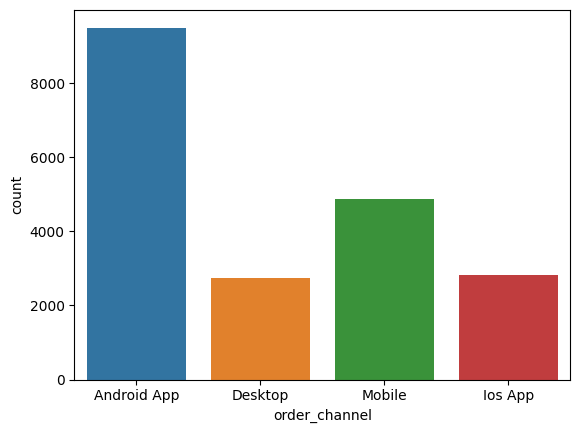

             last_order_channel  Ratio
Android App                6783 0.3400
Offline                    6608 0.3300
Mobile                     3172 0.1600
Ios App                    1696 0.0900
Desktop                    1686 0.0800
*********************************************************


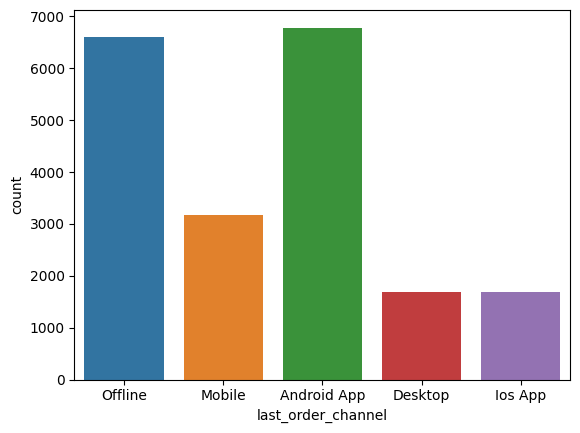

In [9]:
for col in cats:
    cat_summary(df,col,True)

In [10]:
#Summary of Numerical Columns
def num_summary(df, col, plot=False):
    quantiles = [0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 0.95, 0.99]
    print(df[col].describe(quantiles).T)
    print("*****************************************************")
    if plot:
        df[col].hist()
        plt.xlabel(col)
        plt.title(col)
        plt.show(block=True)
        

count   19945.0000
mean        3.1109
std         4.2256
min         1.0000
1%          1.0000
5%          1.0000
10%         1.0000
25%         1.0000
50%         2.0000
75%         4.0000
95%        10.0000
99%        20.0000
max       200.0000
Name: order_num_total_ever_online, dtype: float64
*****************************************************


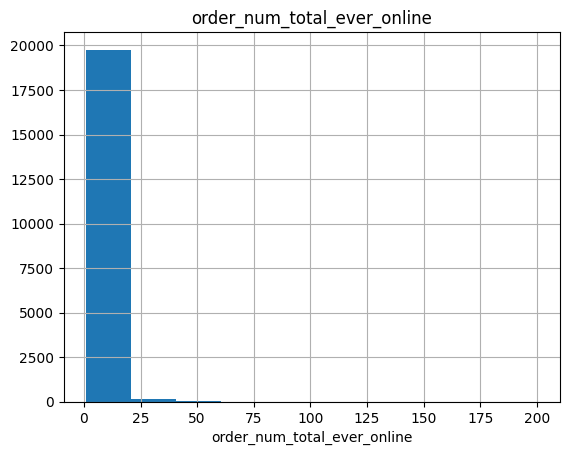

count   19945.0000
mean        1.9139
std         2.0629
min         1.0000
1%          1.0000
5%          1.0000
10%         1.0000
25%         1.0000
50%         1.0000
75%         2.0000
95%         4.0000
99%         7.0000
max       109.0000
Name: order_num_total_ever_offline, dtype: float64
*****************************************************


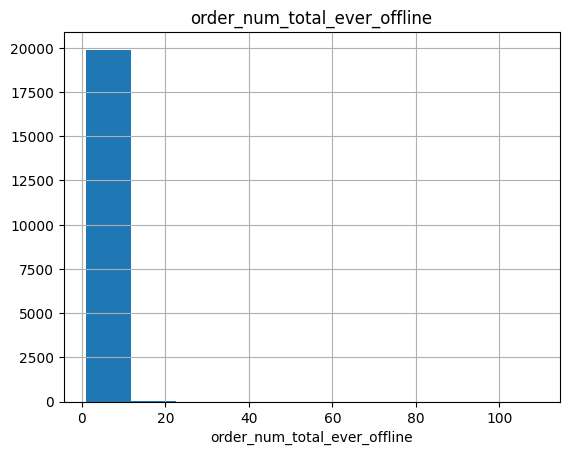

count   19945.0000
mean      253.9226
std       301.5329
min        10.0000
1%         19.9900
5%         39.9900
10%        59.9900
25%        99.9900
50%       179.9800
75%       319.9700
95%       694.2220
99%      1219.9468
max     18119.1400
Name: customer_value_total_ever_offline, dtype: float64
*****************************************************


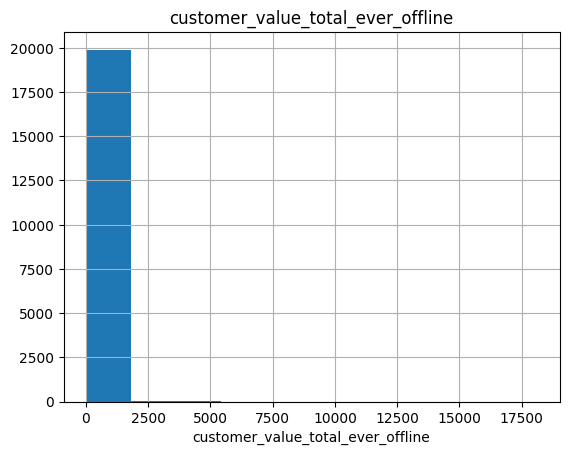

count   19945.0000
mean      497.3217
std       832.6019
min        12.9900
1%         39.9900
5%         63.9900
10%        84.9900
25%       149.9800
50%       286.4600
75%       578.4400
95%      1556.7260
99%      3143.8104
max     45220.1300
Name: customer_value_total_ever_online, dtype: float64
*****************************************************


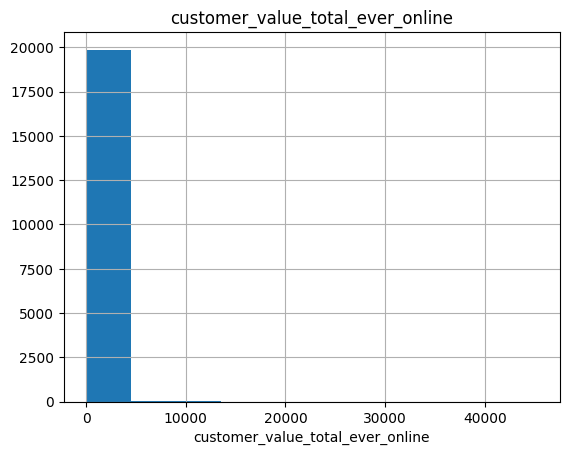

In [11]:
for col in nums:
    num_summary(df,col,True)

In [12]:
#Adding new columns
df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_online"] + df["customer_value_total_ever_offline"]


In [13]:
#Changing column types 
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

In [14]:
df.dtypes

master_id                                    object
order_channel                                object
last_order_channel                           object
first_order_date                     datetime64[ns]
last_order_date                      datetime64[ns]
last_order_date_online               datetime64[ns]
last_order_date_offline              datetime64[ns]
order_num_total_ever_online                 float64
order_num_total_ever_offline                float64
customer_value_total_ever_offline           float64
customer_value_total_ever_online            float64
interested_in_categories_12                  object
order_num_total                             float64
customer_value_total                        float64
dtype: object

## Handling Outliers

In [15]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [16]:
#Replacing may be more useful if removing entire row is not desired
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [17]:
for col in nums:
    print(col, ":", df[col].min(), "-" , df[col].max())

order_num_total_ever_online : 1.0 - 200.0
order_num_total_ever_offline : 1.0 - 109.0
customer_value_total_ever_offline : 10.0 - 18119.14
customer_value_total_ever_online : 12.99 - 45220.13


In [18]:
for col in nums:
    replace_with_thresholds(df,col)

In [19]:
for col in nums:
    print(col, ":", df[col].min(), "-" , df[col].max())

order_num_total_ever_online : 1.0 - 23.5
order_num_total_ever_offline : 1.0 - 8.5
customer_value_total_ever_offline : 10.0 - 1675.5699999999988
customer_value_total_ever_online : 12.99 - 3795.83


## CLT Prediction Preprocesses

In [20]:
#Creating the analysis date
analysis_date = df["last_order_date"].max() + dt.timedelta(days=2)

In [21]:
#Creating cltv dataframe
cltv_df = pd.DataFrame()
#Customer ID
cltv_df["Customer ID"] = df["master_id"]
#Recency by each customer as week
cltv_df["Recency(Week)"] = ((df["last_order_date"] - df["first_order_date"]).astype("timedelta64[D]")) / 7
#Tenure as week
cltv_df["Tenure(Week)"] = ((analysis_date - df["first_order_date"]).astype("timedelta64[D]"))/7
#Frequency
cltv_df["Frequency"] = df["order_num_total"]
#Average Monetary
cltv_df["Average Monetary"] = df["customer_value_total"] / df["order_num_total"]

In [22]:
cltv_df.head()

,Customer ID,Recency(Week),Tenure(Week),Frequency,Average Monetary
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900


## BG/NBD Model
### Expected Sales Prediction

In [23]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['Frequency'],
        cltv_df['Recency(Week)'],
        cltv_df['Tenure(Week)'])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 71.57, b: 0.26, r: 3.48>

In [24]:
#Sales prediction for 3 months
cltv_df["Expected Order Number(3 Months)"] = bgf.predict(4*3, cltv_df["Frequency"], cltv_df["Recency(Week)"], cltv_df["Tenure(Week)"])

In [25]:
#Sales prediction for 6 months
cltv_df["Expected Order Number(6 Months)"] = bgf.predict(4*6, cltv_df["Frequency"], cltv_df["Recency(Week)"], cltv_df["Tenure(Week)"])

In [26]:
cltv_df.head()

,Customer ID,Recency(Week),Tenure(Week),Frequency,Average Monetary,Expected Order Number(3 Months),Expected Order Number(6 Months)
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9960,1.9920
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9909,1.9818
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6763,1.3525
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7111,1.4222
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3936,0.7872


## Gamma-Gamma Submodel
### Expected Revenue Prediction

In [27]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [28]:
ggf.fit(cltv_df['Frequency'], cltv_df['Average Monetary'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [29]:
cltv_df["Expected Average Value"] = ggf.conditional_expected_average_profit(cltv_df["Frequency"], cltv_df["Average Monetary"])

In [31]:
#CLTV Prediction for 6 Months
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['Frequency'],
                                   cltv_df['Recency(Week)'],
                                   cltv_df['Tenure(Week)'],
                                   cltv_df['Average Monetary'],
                                   time=6,  
                                   freq="W",  
                                   discount_rate=0.01)

In [32]:
cltv_df["cltv"] = cltv

In [33]:
#Creating Segments by CLTV
cltv_df["Segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D","C","B","A"]) 

In [34]:
cltv_df.head()

,Customer ID,Recency(Week),Tenure(Week),Frequency,Average Monetary,Expected Order Number(3 Months),Expected Order Number(6 Months),Expected Average Value,cltv,Segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9960,1.9920,193.6328,404.6941,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9909,1.9818,96.6651,201.0020,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6763,1.3525,120.9677,171.6671,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7111,1.4222,67.3201,100.4584,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3936,0.7872,114.3252,94.4271,D


In [37]:
cltv_df.groupby("Segment").agg({
    "cltv" : "mean"
}).sort_values(by="cltv", ascending=False)

,cltv
Segment,
A,372.5150
B,200.4117
C,138.4894
D,80.0061
